In [ ]:
'''
Procedures
1. Generate the ICM spectral model 
1) separate lines with continuum
2) fix temperature?
3) fix abundance?

2. Generate photons 
(XMM response file, exposure time)

3. take median or mean energy from the photons and 
plot the median energy versus the temperature

'''

# 1. Generate the ICM spectral model 

1) generate continuum only spectrum (use nlapec model in xspec)
2) generate total spectrum
Settings
2) fix temperature to 1 keV
3) fix abundance to 0.3 aspl
4) fix norm to 1.5e-3/400pi * 299 
5) fix instrument to PN
6) change the exposure time to 1000Ms

files :
gen_tot_mdl.sh
gen_cont_mdl.sh

In [3]:
import numpy as np
import os 

In [16]:
## for totinuum spectrums
# settings
INST = 'pn'
t_exp = 1e9 # sec

T_arr = np.arange(0.1, 3.1, 0.1) # keV
reds = 0.05
nH = 0
abun = 0.3
A = 299.47
norm = 1.5e-3/400/np.pi * A

workdir = '/Users/eusracenorth/Documents/work/EXTG/ideal_mdls/'
codedir = os.chdir(f'{workdir}/bin')

data_savepath = os.makedirs(f'{workdir}/sep_lines_tot', exist_ok=True)

f = open(f'gen_tot_mdl.sh', 'w')

f.write('''
rm ../mdls/tot*.xcm
xspec << EOT
@../sample_mdls/tot-mdl_nH_1e20_z_005_norm_1_T_1.xcm
''')
for T in T_arr:
    f.write(f'''
abun aspl
new 1 {nH}
new 2 {T}
new 3 {abun}
new 4 {reds}
new 5 {norm}
save mo ../mdls/tot_ideal-mdl_nH_1e20_z_005_suzakunorm_15e-4_{INST}_A{int(A)}_T_{T:.1f}_abun{abun:.1f}_nH{nH:.2f}.xcm
''')

f.write('EOT')
f.close()


# 2. Generate photons 
file: 
mock_spec_tot_cont.sh


In [17]:
#!/bin/bash

# Define your input filenames
exposure_time=1000000000               # Replace with your desired exposure time in seconds
output_dir="../mock_spectras"  # Replace with your desired output directory

# Create the output directory if it doesn't exist
mkdir -p "$output_dir"


# Loop through XCM files in the current directory and generate mock spectra
for inst in pn; do
resp_file="${output_dir}/${inst}.rmf"  # Replace with your XMM response file
arf_file="${output_dir}/${inst}.arf"
for head in tot cont; do
rm $output_dir/*$head*.fak
for xspec_model_file in ../mdls/${head}*${inst}*.xcm; do
# Extract the model name (excluding the .xcm extension) from the file
model_name="$(basename "$xspec_model_file" | sed 's/\.xcm$//')"
# Define the output spectrum filename based on the model name
output_spectrum="$output_dir/mock_spectrum_${model_name}.fak"

# Run XSpec in batch mode to generate the mock spectrum
xspec <<EOF
log >${output_spectrum}.log # no space after >!
data none               # Clear any existing data
@$xspec_model_file # Load the XCM model file
fakeit none
$resp_file  
$arf_file
n

$output_spectrum
$exposure_time, 1, 0
log none
exit
EOF

echo "Mock spectrum for $model_name generated and saved as $output_spectrum"
done
done
done

SyntaxError: invalid syntax (1792201779.py, line 8)

# 3. take median or mean energy from the photons 

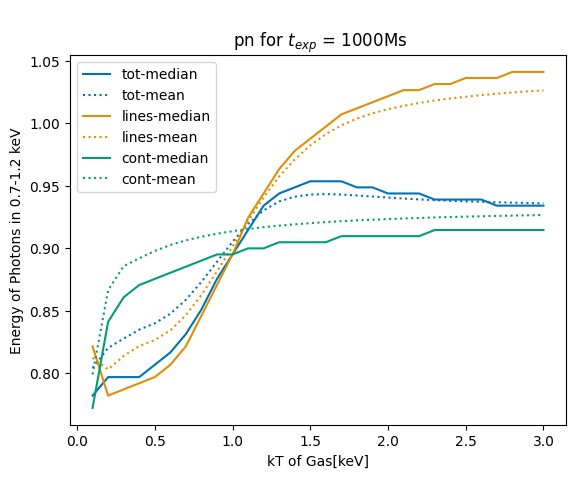

In [14]:
'''
1. load channel to energy in rmf file
2. load spectrum counts in 0.7-1.2 keV
3. cal median of the photons
'''

cb = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']

os.chdir(f'/Users/eusracenorth/Documents/work/EXTG/ideal_mdls/mock_spectras')
from astropy.io import fits
from glob import glob
import matplotlib.pyplot as plt
import numpy as np


def ctr2photons_from_spec(filename, time_exp, energy_msk, energy_range):
    fak_file = fits.open(filename)
    ctr = fak_file[1].data['RATE']
    cts = np.array(ctr[energy_msk] * time_exp).astype(int)
    data_arr = np.repeat(energy_range, cts)

    return data_arr

def gen_photons_for_lines(tot_filename, cont_filename, time_exp, energy_msk, energy_range):
    tot_file = fits.open(tot_filename)
    cont_file = fits.open(cont_filename)

    tot_ctr = tot_file[1].data['RATE']
    cont_ctr = cont_file[1].data['RATE']
    ctr = tot_ctr - cont_ctr

    cts = np.array(ctr[energy_msk] * time_exp).astype(int)
    data_arr = np.repeat(energy_range, cts)

    return data_arr


T_arr = np.arange(0.1, 3.1, 0.1)
t_exp = 1000000000


for INST in ['pn']: # 'mos1', 'mos2', 'pn'
    # load and filter the energy range
    rmf_file = fits.open(f'{INST}.rmf')
    Elo = rmf_file[2].data['E_MIN']
    # print(Elo)
    # filter ctr in 0.7-1.2 keV
    E_msk = (Elo>0.7) & (Elo<1.2)
    E_range = Elo[E_msk]

    # initialize  
    result_dict ={}
    for type in ['tot', 'lines', 'cont']:
        result_dict[type] = {'med': np.zeros(T_arr.shape), 'mean': np.zeros(T_arr.shape), 'sum': np.zeros(T_arr.shape)}

    for i, T in enumerate(T_arr):
        tot_filename = glob(f'mock*tot*{INST}*T_{T:.1f}*abun*.fak')[0]
        cont_filename = glob(f'mock*cont*{INST}*T_{T:.1f}*abun*.fak')[0]

        cts_dir = {}
        cts_dir['tot'] = ctr2photons_from_spec(tot_filename, t_exp, E_msk, E_range)
        cts_dir['cont'] = ctr2photons_from_spec(cont_filename, t_exp, E_msk, E_range)
        cts_dir['lines'] = gen_photons_for_lines(tot_filename, cont_filename, t_exp, E_msk, E_range)
    
        for type in ['tot', 'lines', 'cont']:
            result_dict[type]['med'][i] = np.median(cts_dir[type])
            result_dict[type]['mean'][i] = np.mean(cts_dir[type])
            result_dict[type]['sum'][i] = np.sum(cts_dir[type])

    # make the plot
    fig = plt.subplots()

    for k, type in enumerate(['tot', 'lines', 'cont']):
        plt.plot(T_arr, result_dict[type]['med'], label = f'{type}-median', c = cb[k])
        plt.plot(T_arr, result_dict[type]['mean'], label = f'{type}-mean', c = cb[k], linestyle = 'dotted')
        # plt.plot(T_arr, result_dict[type]['sum'], label = f'{type}-sum', c = cb[k])

    plt.title(f'\n {INST} for $t_{{exp}}$ = 1000Ms')
    # plt.ylabel('Counts [cts]')
    plt.ylabel('Energy of Photons in 0.7-1.2 keV')
    plt.xlabel('kT of ICM [keV]')
    plt.legend()




In [8]:
import seaborn as sns
print(sns.color_palette("colorblind").as_hex())

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


In [7]:
pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 9.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np